In [ ]:
polygon_ID = 291

# National Intertidal Digital Elevation Model (NIDEM)

**What does this notebook do?** This notebook uses the ITEM 2.0 product to compute continuous elevation data for Australia's intertidal zone. It initially imports ITEM REL files and median tidal elevations for each tidal interval, computes elevations at interval boundaries, extracts contours around each tidal interval, and then interpolates between these contours using TIN/Delaunay triangulation linear interpolation. This interpolation method preserves the tidal interval boundaries of ITEM 2.0. The notebook exports the resulting DEM as a geotiff, the contours used for interpolation as line shapefiles, and a mask geotiff with tags indicating locations of nodata values (== 1), the lowest ITEM interval (2), the highest ITEM interval (3), and ITEM confidence NDWI standard deviation greater than 0.25 (4).

**Date:** April 2018

**Author:** Robbi Bishop-Taylor

## Load modules and define functions

In [5]:
# Import libraries
import sys
import os
import glob
import fiona
import itertools
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import statsmodels.formula.api as sm
from collections import OrderedDict
from shapely.geometry import Point, LineString, MultiLineString, mapping
from pyproj import Proj, transform
from fiona.crs import from_epsg
from osgeo import gdal
import scipy.interpolate 
from scipy import ndimage as nd
from scipy import stats
from skimage import measure
from matplotlib import pyplot as plt
from IPython.display import display

# Import DEA Notebooks scripts
sys.path.append(os.path.expanduser('~/dea-notebooks/Scripts'))
import SpatialTools 


def fill(data, invalid=None):
    """
    Replace value of invalid cells by the value of the nearest 
    cell with valid data

    :attr data: numpy array of any dimension
    :attr invalid: a binary array of same shape as 'data'. Data value 
                   are replaced where invalid is True. Defaults to 
                   np.isnan(data) if no layer is given

    :returns: Array with invalid values filled with nearest valid data value
    """    
    
    # If no invalid array is given, default to setting invalid based on nan
    if invalid is None:
        
        invalid = np.isnan(data)

    ind = nd.distance_transform_edt(invalid, 
                                    return_distances=False, 
                                    return_indices=True)
    
    return data[tuple(ind)]


## Set up analysis
Set up path to data and polygon to process. `plotting_subset` does not affect the analysis, but can be used to provide more useful zoomed-in plots.

In [27]:
# Working directory
os.chdir("/g/data/r78/rt1527/nidem")

# Path to ITEM offset product
item_offset_path = "/g/data2/v10/ITEM/offset_products"
item_relative_path = "/g/data2/v10/ITEM/rel_products"
item_conf_path = "/g/data2/v10/ITEM/conf_products"

# Set ITEM polygon for analysis
polygon_ID = 95
# Issues with # 18, 131, 162, 172, 204, 220, 226, 238, 240, 301

# Zoom-in for plots (has no effect on analysis but allows you to plot a zoomed-in subset)
plotting_subset = np.index_exp[:, :]
# plotting_subset = np.index_exp[2000: 2400, 1500:1750]

# Print run details
print("Processing polygon {0} from {1}".format(polygon_ID, item_offset_path))

Processing polygon 95 from /g/data2/v10/ITEM/offset_products


## ITEM interval boundary value extraction
ITEM offset values represent the median tidal height for each tidal interval ([Sagar et al. 2015](https://doi.org/10.1016/j.rse.2017.04.009)). Because ITEM tidal intervals are linearly spaced by design, this code uses a simple linear model to compute new offset values for each interval boundary (e.g. the boundary between ITEM interval 1 and 2). This allows us to assign a more appropriate tidal height to the contours that divide the ITEM tidal intervals than would be possible through simply assigning median tidal heights to the downhill or uphill contours. 

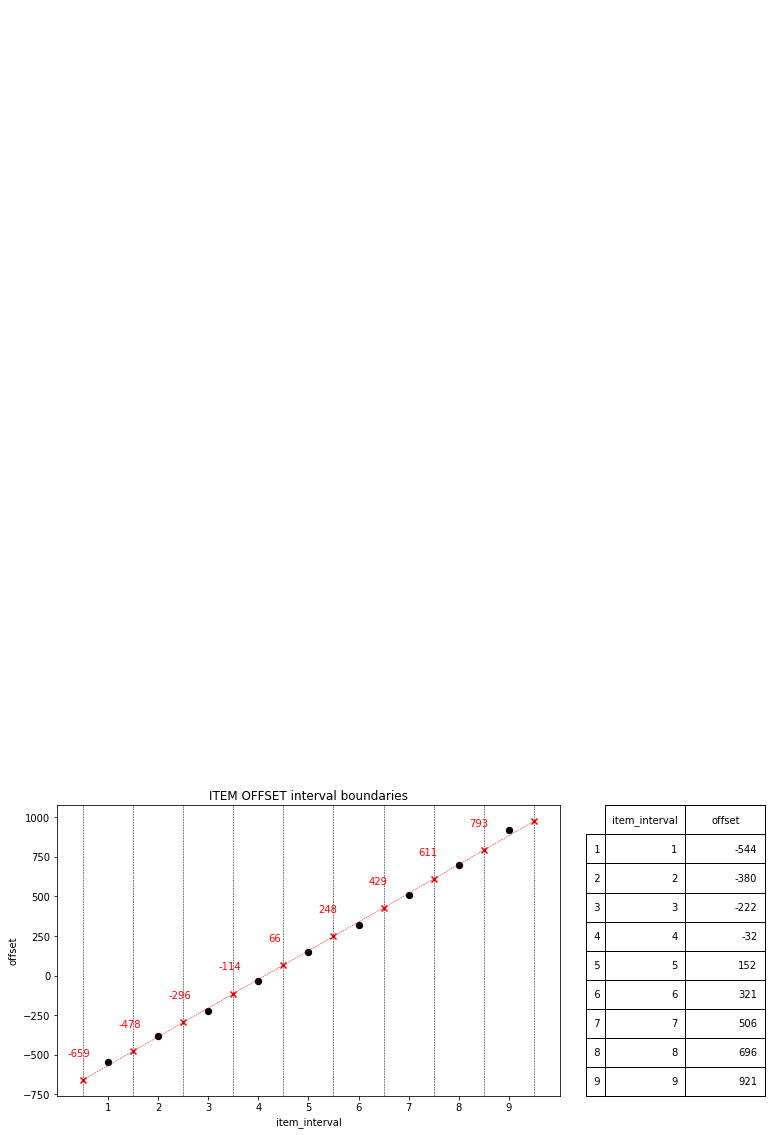

In [28]:
# Import ITEM offset values for each ITEM tidal interval
item_offsets = np.loadtxt("{}/elevation.txt".format(item_offset_path), delimiter = ",", dtype = "str")
item_offsets = {int(key):[int(val) for val in value.split(" ")] for (key, value) in item_offsets}
interval_offsets = item_offsets[polygon_ID]

# Create dataframe of offset values by ITEM interval
interval_offsets_df = pd.DataFrame({"item_interval": range(1,10), "offset": interval_offsets})

# Compute linear model and calculate ITEM offsets at the boundary of each ITEM interval 
# (ensures that extracted contours are placed precisely on the boundary of ITEM intervals)
m, b = np.polyfit(interval_offsets_df["item_interval"], interval_offsets_df["offset"], 1)
interval_boundaries = np.arange(0.5, 10.5, 1.0)
contour_offsets = (m * interval_boundaries + b).astype(int)

# Compute ITEM offset interval used to fill lowest class of ITEM relative layer 
# (not used for interpolation, but ensures lowest contour is placed exactly on interval boundary)
interval_zero = (m * 0 + b).astype(int)

# Plot output
fig, ax = plt.subplots(figsize = (8, 5))
interval_offsets_df.plot(kind = "scatter", x = "item_interval", y = "offset", s = 40, 
                         color = "black", xticks=interval_offsets_df['item_interval'], ax = ax)
ax.scatter(interval_boundaries, contour_offsets, color = 'red', marker = "x")
ax.plot(interval_boundaries, contour_offsets, color = 'red', linestyle = '--', lw = 0.5)
for xc in interval_boundaries:
    plt.axvline(x = xc, color = 'k', linestyle = '--', lw = 0.5)
for i, txt in enumerate(contour_offsets):
    ax.annotate(txt, (interval_boundaries[i] - 0.3, contour_offsets[i] + 150), color = "red")
plt.title("ITEM OFFSET interval boundaries")
plt.tight_layout()

# Display table
ax2 = fig.add_subplot(122)
ax2.axis('off')
table = ax2.table(cellText = interval_offsets_df.values, 
                  rowLabels = ["  {} ".format(i) for i in interval_offsets_df.item_interval], 
                  colLabels = interval_offsets_df.columns,
                  bbox = [1.2, 0, 0.7, 1])
table.auto_set_font_size(False)
table.set_fontsize(10)


## Import and prepare ITEM offset raster
Imports ITEM REL raster for given polygon, and use a lookup index array of offset values to classify into a new array of evenly-spaced ITEM offset values (in *mm* units relative to sea level) suitable for contour extraction. 

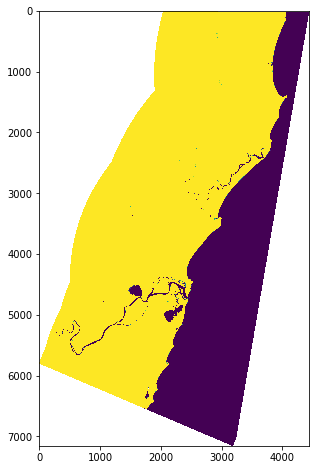

In [29]:
# Import raster and extract shape, projection info and geotransform data
item_filename = glob.glob("{}/ITEM_REL_{}_*.tif".format(item_relative_path, polygon_ID))[0]
item_ds = gdal.Open(item_filename)
item_array = item_ds.GetRasterBand(1).ReadAsArray() 
yrows, xcols = item_array.shape
prj = item_ds.GetProjection()
geotrans = item_ds.GetGeoTransform()
upleft_x, x_size, x_rotation, upleft_y, y_rotation, y_size = geotrans

# Temporarily assign nodata -6666 values to new class 10 prior to lookup classification
item_array[item_array == -6666] = 10
 
# Create lookup index array, and index by ITEM relative layer to classify into offset values
# (this method should be resilient to ITEM layers with fewer than 9 classes)
test_lut = np.array([interval_zero] + interval_offsets + [np.nan])
offset_array = test_lut[item_array]

# Dilate data area of array by two pixels to eliminate NA contours on tile edges
# (this only affects pixels directly on the boundary of two polygon arrays)
dilated_array = nd.morphology.binary_dilation(~np.isnan(offset_array),  iterations = 2)
offset_array = fill(offset_array)
offset_array[~dilated_array] = np.nan

# Plot original data
plt.figure(figsize = (8, 8))
plt.imshow(offset_array[plotting_subset])  
plt.show()


## Extract contours
Uses `scikit.measure.find_contours` to rapidly extract contour boundaries between ITEM tidal intervals, and assigns these contours with previously calculated elevation values. Contours are exported as line shapefiles to assist in subsequent assessment of output DEMs.

In [24]:
# Output dict to hold contours for each offset
contour_dict = OrderedDict()

try:
    for contour_offset in contour_offsets:

        # Extract contours from array
        contours = measure.find_contours(offset_array, contour_offset)      
        print("Extracting contour {}".format(contour_offset))
        
        # Iterate through each contour feature, remove NAs and fix coordinates
        contour_list = list()
        for contour in contours:

            # Convert index coordinates to spatial coordinates in-place
            contour[:, 0] = contour[:, 0] * float(y_size) + upleft_y + (float(y_size) / 2)
            contour[:, 1] = contour[:, 1] * float(x_size) + upleft_x + (float(x_size) / 2)        
            contour = np.insert(contour, 2, contour_offset, axis = 1)

            # Remove contour points with NAs
            contour = contour[~np.isnan(contour).any(axis=1)] 
            contour_list.append(contour)

        # Add list of contour arrays to dict 
        contour_dict[contour_offset] = contour_list
except:
    print("fail")

    
# Export contours to line shapefile to assist in evaluating DEMs
schema = {'geometry':  'MultiLineString', 
          'properties': { 'elevation': 'int' } }      

with fiona.open("output_data/contour/NIDEM_contours_{}.shp".format(polygon_ID), "w", 
                crs = from_epsg(3577),
                driver = "ESRI Shapefile", 
                schema = schema) as output:
    
    for elevation_value, contour_list in contour_dict.items():
        
        # Filter out contours with less than two points (i.e. non-lines)
        contour_list = [x for x in contour_list if len(x) > 1]
        
        # Create multiline string by first flipping coordinates then creating list of linestrings
        contour_linestrings = [LineString([(x, y) for (y, x, z) in contour_array]) 
                               for contour_array in contour_list]
        contour_multilinestring = MultiLineString(contour_linestrings)

        # Write output shapefile to file with elevation field        
        output.write({'properties': { 'elevation': int(elevation_value) },
                      'geometry': mapping(contour_multilinestring) })
        
# Chain and concatenate all arrays nested within array lists (i.e. individual collections of same 
# elevation contours) and dictionary entries (i.e. collections of all same-elevation contours)
all_contours = np.concatenate(list(itertools.chain.from_iterable(contour_dict.values())))
points = all_contours[:, 0:2]
values = all_contours[:, 2]


Extracting contour -891
Extracting contour -632
Extracting contour -372
Extracting contour -113
Extracting contour 145
Extracting contour 404
Extracting contour 663
Extracting contour 922
Extracting contour 1182
Extracting contour 1441


## Interpolate contours using TIN/Delaunay triangulation interpolation
Exports a DEM by interpolating previously extracted contours. This uses the linear method from `scipy.interpolate.griddata`, which computes a TIN/Delaunay triangulation of the input data using Qhull before performing linear barycentric interpolation on each triangle.

In [25]:
# Extract bounds of ITEM layer
minx = upleft_x
maxx = upleft_x + (x_size * xcols)
miny = upleft_y + (y_size * yrows)
maxy = upleft_y

# Create interpolation grid (from, to, by values in metre units)
grid_y, grid_x = np.mgrid[maxy:miny:1j * yrows,
                          minx:maxx:1j * xcols]

# Interpolate between points onto grid. This uses the 'linear' method from 
# scipy.interpolate.griddata, which computes a TIN/Delaunay triangulation of the input 
# data with Qhull and performs linear barycentric interpolation on each triangle
print("Interpolating data for polygon {}".format(polygon_ID))
interpolated_array = scipy.interpolate.griddata(points, values, (grid_y, grid_x), method = "linear")


Interpolating data for polygon 48


## Mask interpolated array to keep only good data
Masks the interpolated array to remove areas with nodata, and the lowest and highest elevation intervals from the original ITEM layer (lowest and highest intervals cannot be correctly interpolated as they have no lower or upper bounds). In addition, masks out areas with high ITEM confidence NDWI standard deviation (i.e. areas where inundation patterns are not driven by tidal influences), as elevation offset values in these areas are likely to be invalid.

In [ ]:
# Import ITEM confidence NDWI standard deviation array for polygon
conf_filename = glob.glob("{}/ITEM_STD_{}_*.tif".format(item_conf_path, polygon_ID))[0]
conf_ds = gdal.Open(conf_filename)
conf_array = conf_ds.GetRasterBand(1).ReadAsArray() 

# gbr30_reproj = SpatialTools.reproject_to_template(input_raster='/g/data/r78/rt1527/datasets/GBR30/02_ESRI_Raster/gbr30_ALL/gbr30_all',
#                                                   template_raster=item_filename, 
#                                                   output_raster='scratch/temp_gbr30.tif', 
#                                                   resampling=gdal.GRA_Bilinear, nodata_val=-9999)  

# ausbath09_reproj = SpatialTools.reproject_to_template(input_raster='/g/data/r78/rt1527/datasets/ausbath_09/ausbath_09_v4',
#                                                       template_raster=item_filename, 
#                                                       output_raster='scratch/temp_ausbath09.tif', 
#                                                       resampling=gdal.GRA_Bilinear, nodata_val=-9999)  

# manual_mask = SpatialTools.rasterize_vector(input_data='scratch/manual_mask.shp', cols=xcols, rows=yrows,
#                                             geo_transform=geotrans, projection=prj)

# Create combined mask from all 
# gbr30_array = gbr30_reproj.GetRasterBand(1).ReadAsArray()
# ausbath09_array = ausbath09_reproj.GetRasterBand(1).ReadAsArray()


baddata_mask = np.full(item_array.shape, np.nan)
baddata_mask[item_array == 10] = 1  # areas with nodata in original ITEM layer
baddata_mask[item_array == 0] = 2  # areas in lowest ITEM interval
baddata_mask[item_array == 9] = 3  # areas in highest ITEM interval
baddata_mask[conf_array > 0.25] = 4  # areas with > 0.25 ITEM confidence NDWI STD
baddata_mask[(gbr30_array < -25) & ~manual_mask] = 5  # < -25m areas not contained within manual mask
baddata_mask[(ausbath09_array < -25) & ~manual_mask] = 5  # < -25m areas not contained within manual mask


fig, axes = plt.subplots(nrows=1, ncols=5, figsize = (12, 5))
axes[0].set_title("Manual mask")
axes[0].imshow(manual_mask)
axes[1].set_title("GBR30 -25m mask")
axes[1].imshow(gbr30_mask)
axes[2].set_title("ausbath09 -25m mask")
axes[2].imshow(ausbath09_mask)
axes[3].set_title("ITEM confidence mask")
axes[3].imshow(conf_mask)
axes[4].set_title("Combined mask")
axes[4].imshow(baddata_mask)
plt.show()

# gbr30_reproj = None
# ausbath09_reproj = None


/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater


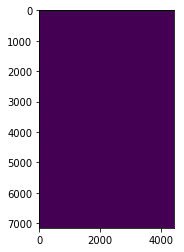

In [87]:
plt.imshow((ausbath09_array < -25)) & ~manual_mask )

In [ ]:
# Import ITEM confidence NDWI standard deviation array for polygon
conf_filename = glob.glob("{}/ITEM_STD_{}_*.tif".format(item_conf_path, polygon_ID))[0]
conf_ds = gdal.Open(conf_filename)
conf_array = conf_ds.GetRasterBand(1).ReadAsArray() 

# Import bathymask
bathy_mask = SpatialTools.rasterize_vector(input_data='scratch/bathym_25m_mask2.shp', cols=xcols, 
                                           rows=yrows, geo_transform=geotrans, projection=prj)
manual_mask = SpatialTools.rasterize_vector(input_data='scratch/manual_mask.shp', cols=xcols, rows=yrows,
                                           geo_transform=geotrans, projection=prj)

# Create mask flagging nodata values (== 1), lowest ITEM interval (2), highest ITEM 
# interval (3), and ITEM confidence NDWI standard deviation greater than 0.25 (4)
baddata_mask = np.full(item_array.shape, np.nan)
baddata_mask[item_array == 10] = 1  # areas with nodata in original ITEM layer
baddata_mask[item_array == 0] = 2  # areas in lowest ITEM interval
baddata_mask[item_array == 9] = 3  # areas in highest ITEM interval
baddata_mask[conf_array > 0.25] = 4  # areas with > 0.25 ITEM confidence NDWI STD
baddata_mask[(bathy_mask == 0) & (manual_mask == 0)] = 5  # bathy and manual mask

# Mask DEM to keep only data with no bad data flags
print("Masking data for polygon {}".format(polygon_ID))
interpolated_array[~np.isnan(baddata_mask)] = np.nan

# Plot output interpolated and masked DEM
plt.figure(figsize = (9, 9))
plt.imshow(interpolated_array[plotting_subset])
plt.show()

# Export resulting DEM as a geotiff
print("Exporting DEM for polygon {}".format(polygon_ID))
SpatialTools.array_to_geotiff(fname = "output_data/dem/NIDEM_dem_{}.tif".format(polygon_ID), 
                              data = interpolated_array, 
                              geo_transform = geotrans, 
                              projection = prj, 
                              nodata_val = np.nan)

# Export mask to geotiff
SpatialTools.array_to_geotiff(fname = "output_data/mask/NIDEM_mask_{}.tif".format(polygon_ID), 
                              data = baddata_mask, 
                              geo_transform = geotrans, 
                              projection = prj, 
                              nodata_val = np.nan,
                              dtype=gdal.GDT_Byte)

# Close files
conf_ds = None
item_ds = None


## Generate virtual rasters for easy visualisation

In [ ]:
# os.system('gdalbuildvrt NIDEM_dem.vrt output_data/dem/NIDEM_dem*.tif')
# os.system('gdalbuildvrt ITEM_rel.vrt /g/data2/v10/ITEM/rel_products/ITEM_REL*.tif')